# Redes Neuronales Artificiales: Trabajo Práctico 2


#### Integrantes:

- Maximiliano Dacko, LU  284/21
- María Marino, LU 450/21
- Giovanni Franco Gabriel Marraffini, LU 292/21

-----

### Descripción del conjunto de datos

El dataset consiste en documentos con descripciones de texto correspondientes a compañías brasileñas clasificadas en nueve categorías distintas. Los textos originales fueron preprocesados para obtener una *Bag-of-Words* de cada uno de ellos.

La primera columna representa la categoría a la cual pertenece la instancia. Las columnas subsiguientes representan, para cada palabra exceptuando preposiciones y artículos comunes, la frecuencia de dicha palabra en el texto original.

### Preliminares: importación de librerías, carga de datos y estandarización

Importamos las librerías necesarias:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Descargamos los datos:

In [ ]:
import requests
r = requests.get('https://git.exactas.uba.ar/redes-neuronales/clases/-/raw/master/practicas/datos/tp2_training_dataset.csv')
data = np.loadtxt(r.iter_lines(), delimiter = ',')

Separamos las categorías incluídas en el dataset (primera columna) del los *features* de cada instancia:

In [ ]:
labels = [int(c) for c in data[:,0]]
data = data[:,1:]

data.shape

(900, 856)

El dataset contiene 900 instancias, con 856 _features_ cada una.

Estandarizamos los _features_ utilizando la fórmula

$$ \tilde{x} = \frac{x - \mu}{\sigma}$$

Donde $\tilde{x}$ es el valor estandarizado, $x$ es el valor original, $\mu$ es la media del dataset y $\sigma$ su desvío estándar.

In [ ]:
data = (data - data.mean()) / data.std()

## Ejercicio 1: Reducción de dimensiones con Oja y Sanger

El objetivo en este ejercicio será reducir la alta dimensionalidad de las instancias a sólo nueve dimensiones. Para esto utilizaremos las reglas de aprendizaje de Oja y de Sanger.

### Función `dimReduction`

Creamos una función que nos permita rápidamente utilizar los algoritmos de Oja y Sanger.

Como **argumentos** recibe:
- `X`: el dataset de entrada
- `dimOutput`: la dimensión deseada de salida
- `method`: el método a utilizar (`Oja` ó `Sanger`)
- `eta`: el _learning rate_ a utilizar en el entrenamiento
- `epochs`: la cantidad de épocas en las que se va a entrenar el modelo
- `seed`: la semilla para utilizar en la incialización de la matriz de pesos (por default utilizamos como semilla 3)

Como **salida** devuelve la matriz de entrada mutiplicada por la matriz de pesos de la red entrenada. Esto equivale al sub-espacio de `dimOutput` dimensiones encontrado por el modelo. Lo implementamos de esta manera para poder, con el resultado, graficar el espacio resultante y verificar si es satisfactorio.

Adicionalmente, cada 100 épocas la función imprime una métrica de **ortogonalidad** de las dimensiones actuales:

$$ \text{Orthogonality} = \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{M} \left| \left( W^T \cdot W - I_M \right)_{ij} \right|$$

Donde $N$ es la cantidad de instancias del dataset, $M$ es la dimensión deseada de salida (o `dimOutput`) y $W$ es la matriz de pesos de tamaño $N$ por $M$.

Idealmente, esta métrica tiende a cero a medida que pasan las épocas, ya que esto indicaría que el modelo encontró un sub-espacio de menor dimensión en donde representar los datos preservando más información.


In [ ]:
def dimReduction(X: np.array, dimOutput: int, method: str, eta: float, epochs: int, seed: int = None):
    if seed: 
        rng = np.random.default_rng(seed) 
    else:
        rng = np.random
    I = X.shape[0]
    N = X.shape[1]
    W = rng.normal(loc = 0.0, scale = 0.5, size = (N, dimOutput))
    dW = np.zeros(W.shape)

    for _ in range(epochs):
        for i in range(I):
            Xi = X[i].reshape(1,N)
            Y = np.dot(Xi, W) 
            if method == 'Oja':
                Z = np.dot(Y, W.T)
                dW = np.outer(Xi - Z, Y)
            elif method == 'Sanger':
                D = np.triu(np.ones((dimOutput,dimOutput)))
                Z = np.dot(W, Y.T * D)
                dW = (Xi.T - Z) * Y
            else:
                raise ValueError(f'Unsupported value: {method}. Method must be one of (\'Oja\', \'Sanger\').')
        
            W += eta * dW
            
            # Usualmente la matriz de pesos se anula por un overflow en sus valores
            #  que resulta en operaciones aritméticas con +-inf
            if np.isnan(np.sum(W)): raise OverflowError(f'Overflow in weight matrix at epoch {_}')

        if (_ % 100 == 0 or _ == epochs - 1): print(f'Epoch {_} of {epochs}. \tOrthogonality: {np.sum(np.abs(np.dot(W.T, W) - np.identity(dimOutput) ))/2}')

    return X @ W

#### Función `plotDimReduction`

Creamos una función auxiliar para visualizar en tres dimensiones los resultados de la reducción de dimensionalidad.

In [ ]:
def plotDimReduction(Z: np.array, dimensions_to_plot: list[int], labels: list[int], elev: list[int] = [90, 0, 0], azim: list[int] = [-90, -90, 0]):
    if len(dimensions_to_plot) != 3:
        raise Exception('dimensions_to_plot must be a list of length three')
    else:
        A = dimensions_to_plot[0]
        B = dimensions_to_plot[1]
        C = dimensions_to_plot[2]


    fig = plt.figure(figsize = (30,20))

    # Primer plot, viewpoint standard
    ax = fig.add_subplot(1, 4, 1, projection='3d')
    ax.scatter3D(
        Z[:,A], 
        Z[:,B], 
        Z[:,C], 
        c = labels,
        cmap = 'tab10'
    )
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_xlabel(f'Dimensión {A}')
    ax.set_ylabel(f'Dimensión {B}')
    ax.set_zlabel(f'Dimensión {C}')

    # Segundo plot, viewpoint elev[0], azim[0]
    ax = fig.add_subplot(1, 4, 2, projection='3d')
    ax.scatter3D(
        Z[:,A], 
        Z[:,B], 
        Z[:,C], 
        c = labels,
        cmap = 'tab10'
    )
    ax.view_init(elev[0],azim[0])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_xlabel(f'Dimensión {A}')
    ax.set_ylabel(f'Dimensión {B}')

    # Tercer plot, viewpoint elev[1], azim[1]
    ax = fig.add_subplot(1, 4, 3, projection='3d')
    ax.scatter3D(
        Z[:,A], 
        Z[:,B], 
        Z[:,C], 
        c = labels,
        cmap = 'tab10'
    )
    ax.view_init(elev[1],azim[1])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_xlabel(f'Dimensión {A}')
    ax.set_zlabel(f'Dimensión {C}')

    # Cuarto plot, viewpoint elev[2], azim[2]
    ax = fig.add_subplot(1, 4, 4, projection='3d')
    ax.scatter3D(
        Z[:,A], 
        Z[:,B], 
        Z[:,C], 
        c = labels,
        cmap = 'tab10'
    )
    ax.view_init(elev[2], azim[2])
    ax.get_xaxis().set_ticklabels([])
    ax.get_yaxis().set_ticklabels([])
    ax.get_zaxis().set_ticklabels([])
    ax.set_zlabel(f'Dimensión {C}')
    ax.set_ylabel(f'Dimensión {B}')

    plt.show()

### Entrenamiento con Oja

Tenemos dos hiperparámetros con los cuales experimentar. A priori pensamos que el *learning rate* será bajo ya que el entrenamiento en este tipo de algoritmos es incremental (es decir, se entrena de a una instancia por vez). Asimismo sabemos que no entrenaremos por más de 2500 *epochs* porque tomaría mucho tiempo.

En la etapa de experimentación previa al realizamiento de este trabajo pudimos observar que:

- Un *learning rate* mayor o igual a 0.01 causa un *overflow* en la matriz de pesos. Esto podría remediarse utilizando librerías como `BigFloat` pero decidimos no explorar ese camino.

In [ ]:
zOja = dimReduction(data, dimOutput = 9, method = 'Oja', eta = 0.01, epochs = 10, seed = 207)

OverflowError: Overflow in weight matrix at epoch 0

- *Learning rates* menores a 0.01 pero mayores a 0.0001 resultan en un estancamiento luego de una cierta cantidad de épocas.

In [ ]:
zOja1 = dimReduction(data, dimOutput = 9, method = 'Oja', eta = 0.0001, epochs = 500, seed = 207)

Epoch 0 of 500. 	Orthogonality: 29.891310741768514
Epoch 100 of 500. 	Orthogonality: 0.24008570012508504
Epoch 200 of 500. 	Orthogonality: 0.2617576590883168
Epoch 300 of 500. 	Orthogonality: 0.26550877975611
Epoch 400 of 500. 	Orthogonality: 0.25814179932884274
Epoch 499 of 500. 	Orthogonality: 0.2749391283709989


La variable `zOja1` almacena las novecientas instancias y sus correspondientes valores para las nueve dimensiones del sub-espacio encontrado por el modelo. Las graficaremos para intentar observar qué tanto se preservó la separación de las categorías originales. Cada punto representará una instancia, cada eje una dimensión de salida, y cada color una categoría de las provistas en el dataset original (*ground truth*).

Aún con el estancamiento podría pasar que el modelo reduzca exitosamente las dimensiones del dataset, pero vemos que no es así:

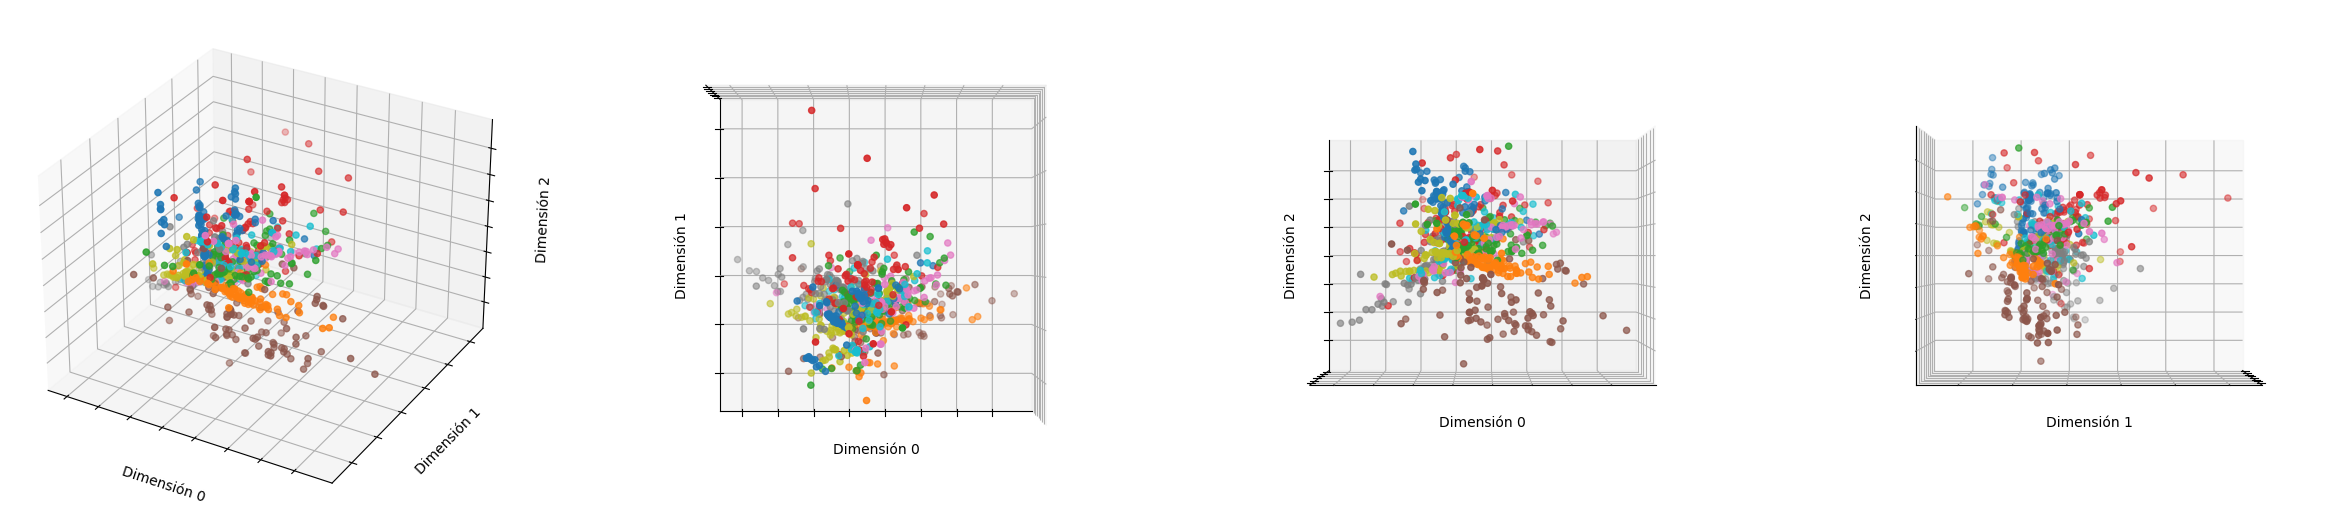

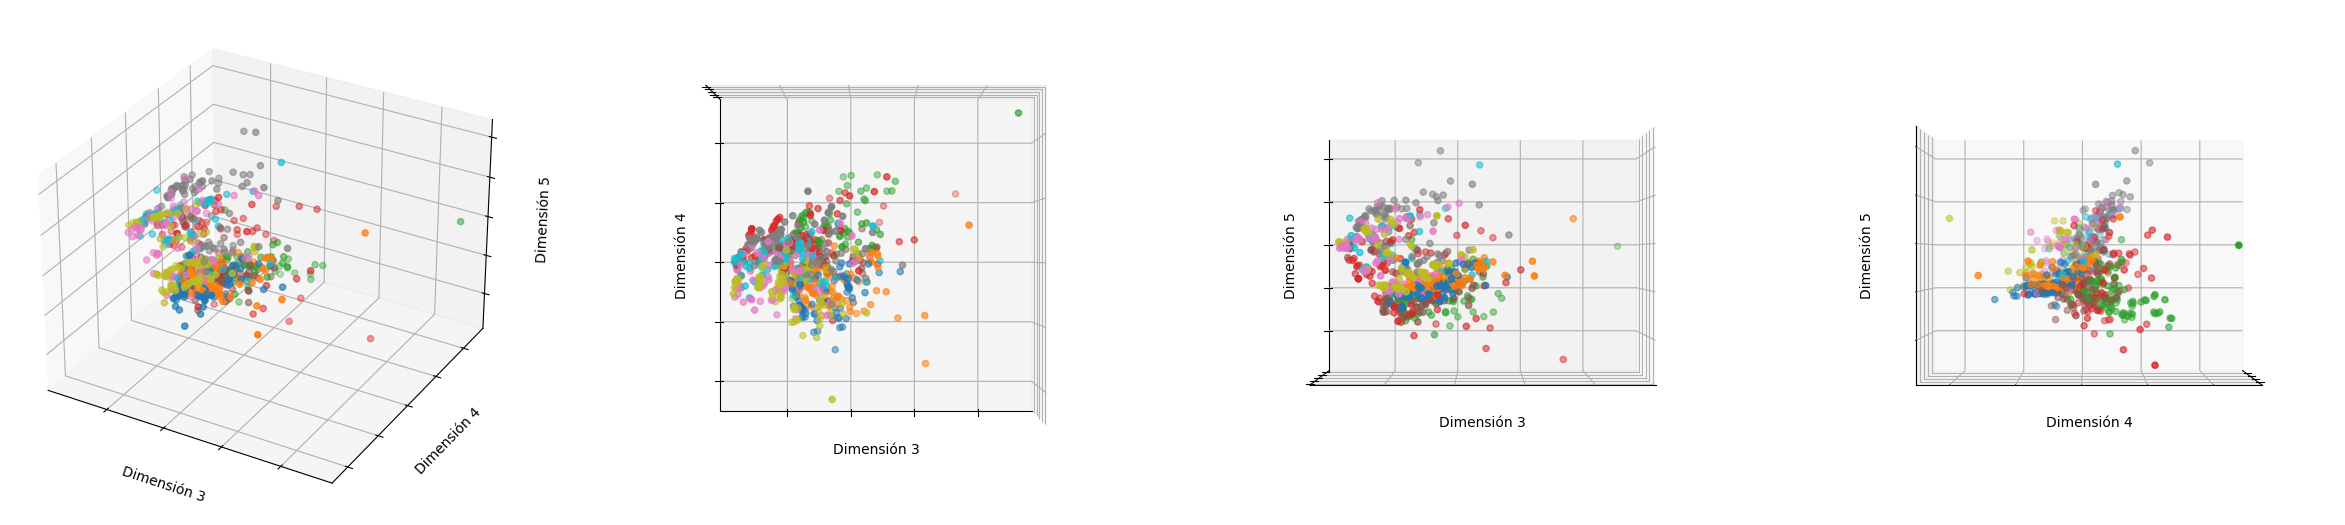

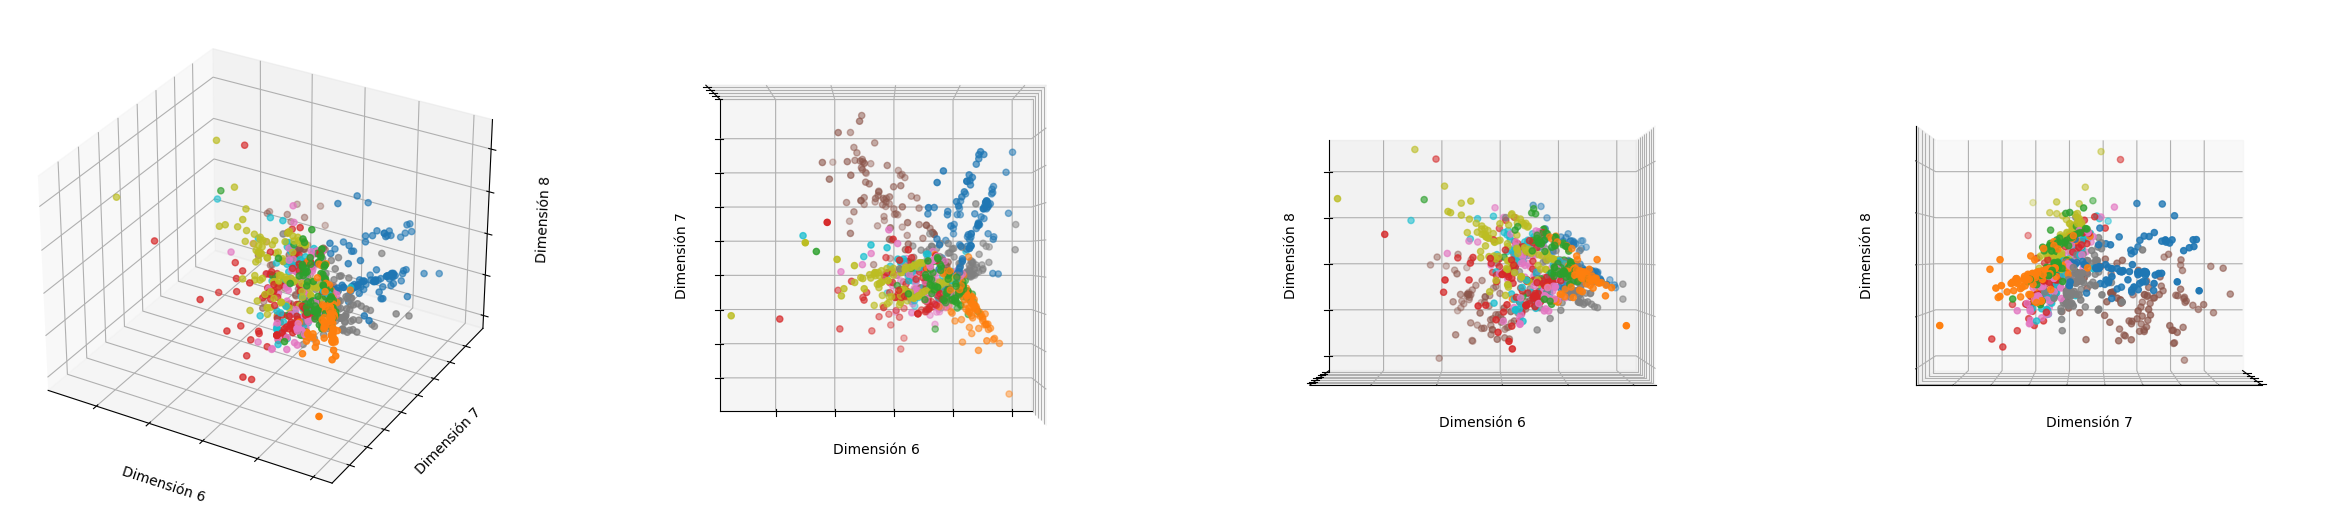

In [ ]:
plotDimReduction(zOja1, [0,1,2], labels=labels)
plotDimReduction(zOja1, [3,4,5], labels=labels)
plotDimReduction(zOja1, [6,7,8], labels=labels)

- Por último, luego de experimentar con distintos _learning rates_ llegamos a que valores menores a 0.00001 nos brindaban los mejores resultados, en particular:

In [ ]:
zOja2 = dimReduction(data, dimOutput = 9, method = 'Oja', eta = 0.000001, epochs = 1000, seed = 207)

Epoch 0 of 1000. 	Orthogonality: 938.96533328057
Epoch 100 of 1000. 	Orthogonality: 28.053397288142804
Epoch 200 of 1000. 	Orthogonality: 4.456440609417593
Epoch 300 of 1000. 	Orthogonality: 0.49760696056860243
Epoch 400 of 1000. 	Orthogonality: 0.04363925304405973
Epoch 500 of 1000. 	Orthogonality: 0.005424264173008711
Epoch 600 of 1000. 	Orthogonality: 0.0025373979669065347
Epoch 700 of 1000. 	Orthogonality: 0.0023751090390067035
Epoch 800 of 1000. 	Orthogonality: 0.002361508047500734
Epoch 900 of 1000. 	Orthogonality: 0.002355872248642294
Epoch 999 of 1000. 	Orthogonality: 0.002350661884627914


Si bien se estanca en las últimas ~300 épocas, los resultados son muy buenos ya que podemos ver a las nueve categorías bastante bien diferenciadas:

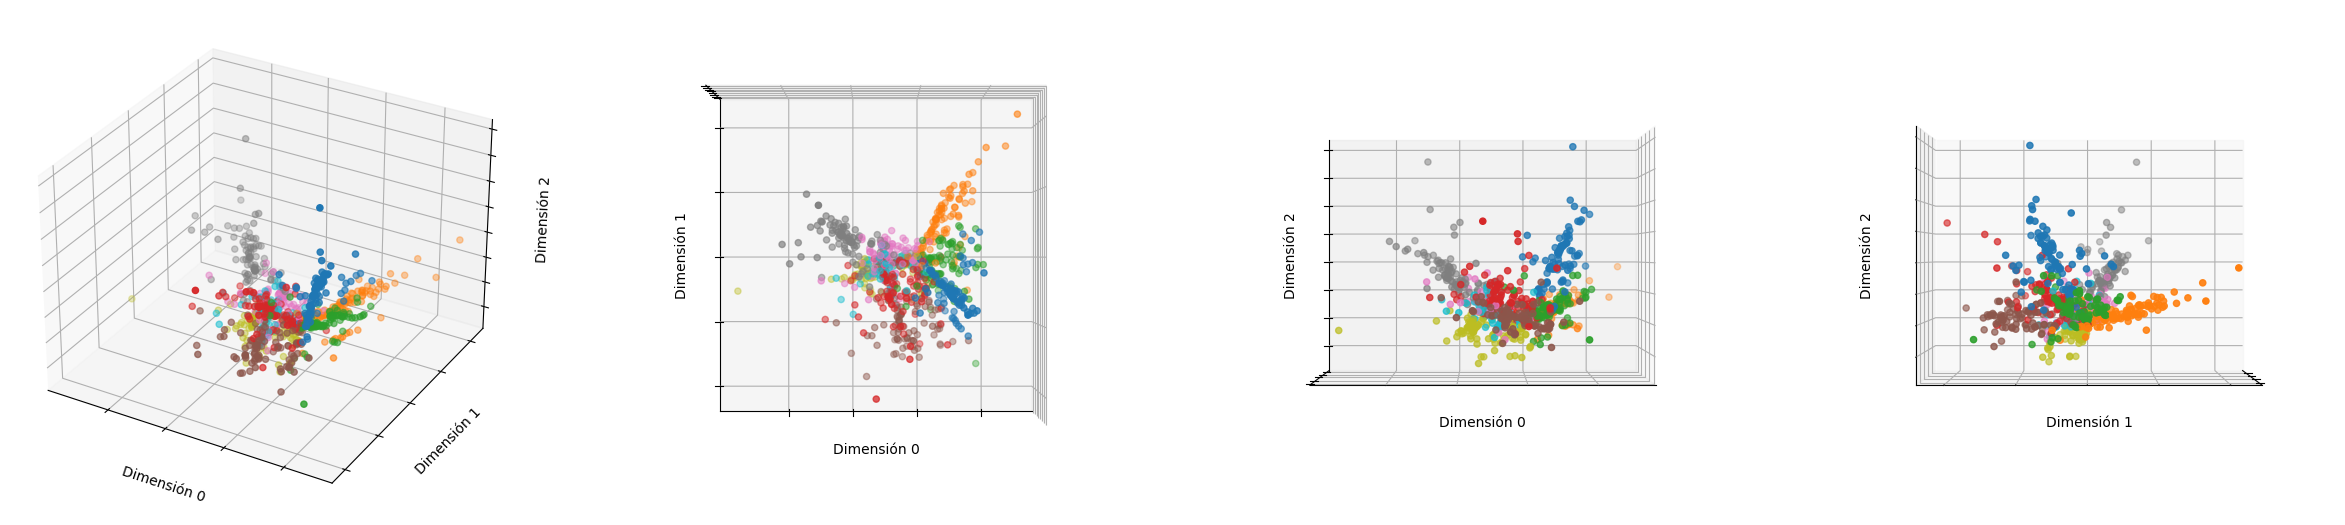

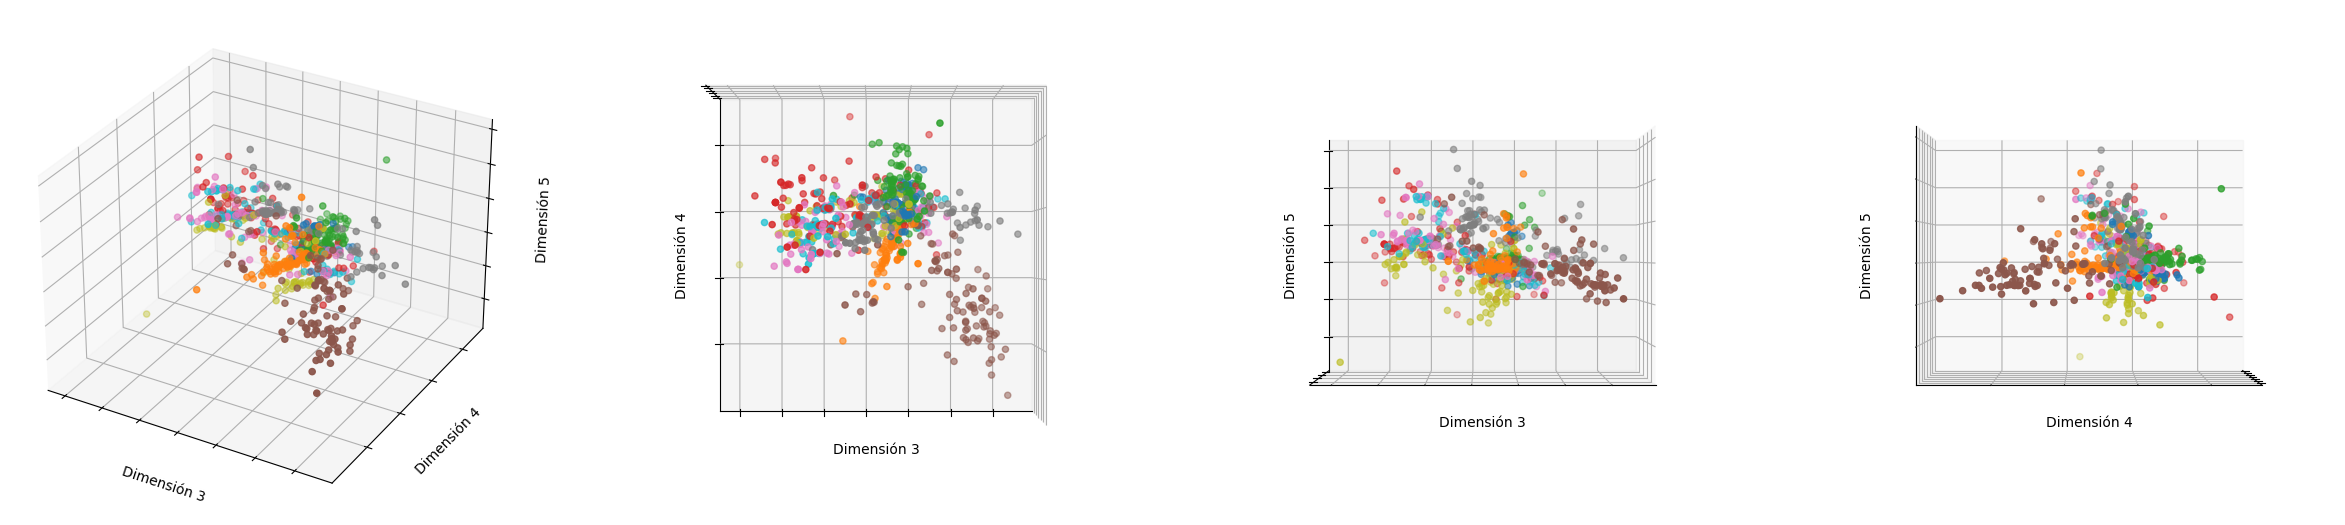

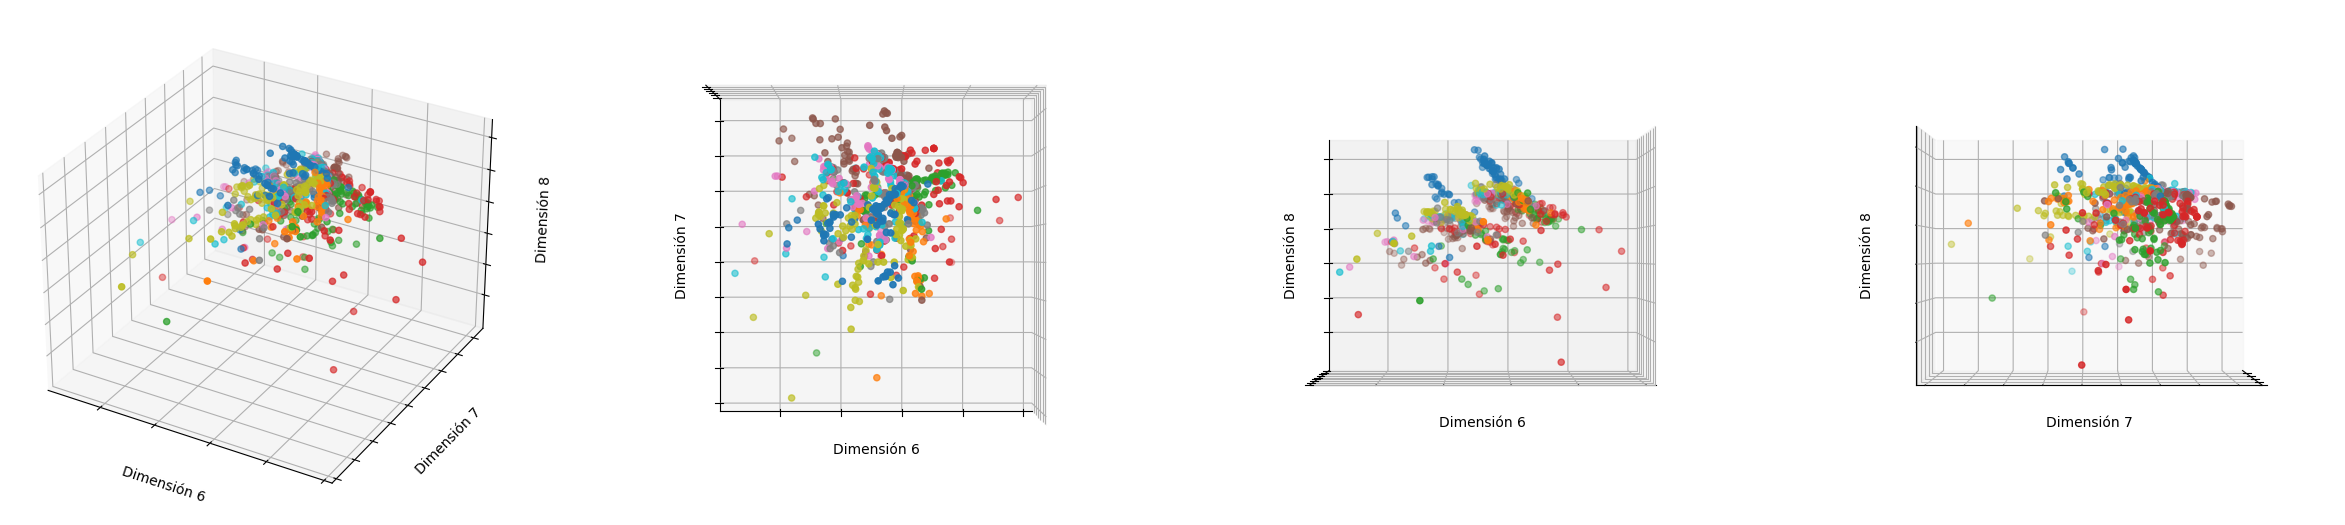

In [ ]:
plotDimReduction(zOja2, [0,1,2], labels=labels)
plotDimReduction(zOja2, [3,4,5], labels=labels)
plotDimReduction(zOja2, [6,7,8], labels=labels)

### Entrenamiento con Sanger

Para empezar probamos con los mismos hiperparámetros que nos dieron buenos resultados con el método de Oja:

In [ ]:
zSanger1 = dimReduction(data, dimOutput = 9, method = 'Sanger', eta = 0.000001, epochs = 1000, seed = 207)

Epoch 0 of 1000. 	Orthogonality: 850.5439014690534
Epoch 100 of 1000. 	Orthogonality: 10.113408305188052
Epoch 200 of 1000. 	Orthogonality: 2.517704980118589
Epoch 300 of 1000. 	Orthogonality: 2.018088030645106
Epoch 400 of 1000. 	Orthogonality: 1.3185423678553212
Epoch 500 of 1000. 	Orthogonality: 0.8840910579694858
Epoch 600 of 1000. 	Orthogonality: 0.5923455282628882
Epoch 700 of 1000. 	Orthogonality: 0.4265580462835688
Epoch 800 of 1000. 	Orthogonality: 0.31281241761343026
Epoch 900 of 1000. 	Orthogonality: 0.23303561917539112
Epoch 999 of 1000. 	Orthogonality: 0.1810526825077562


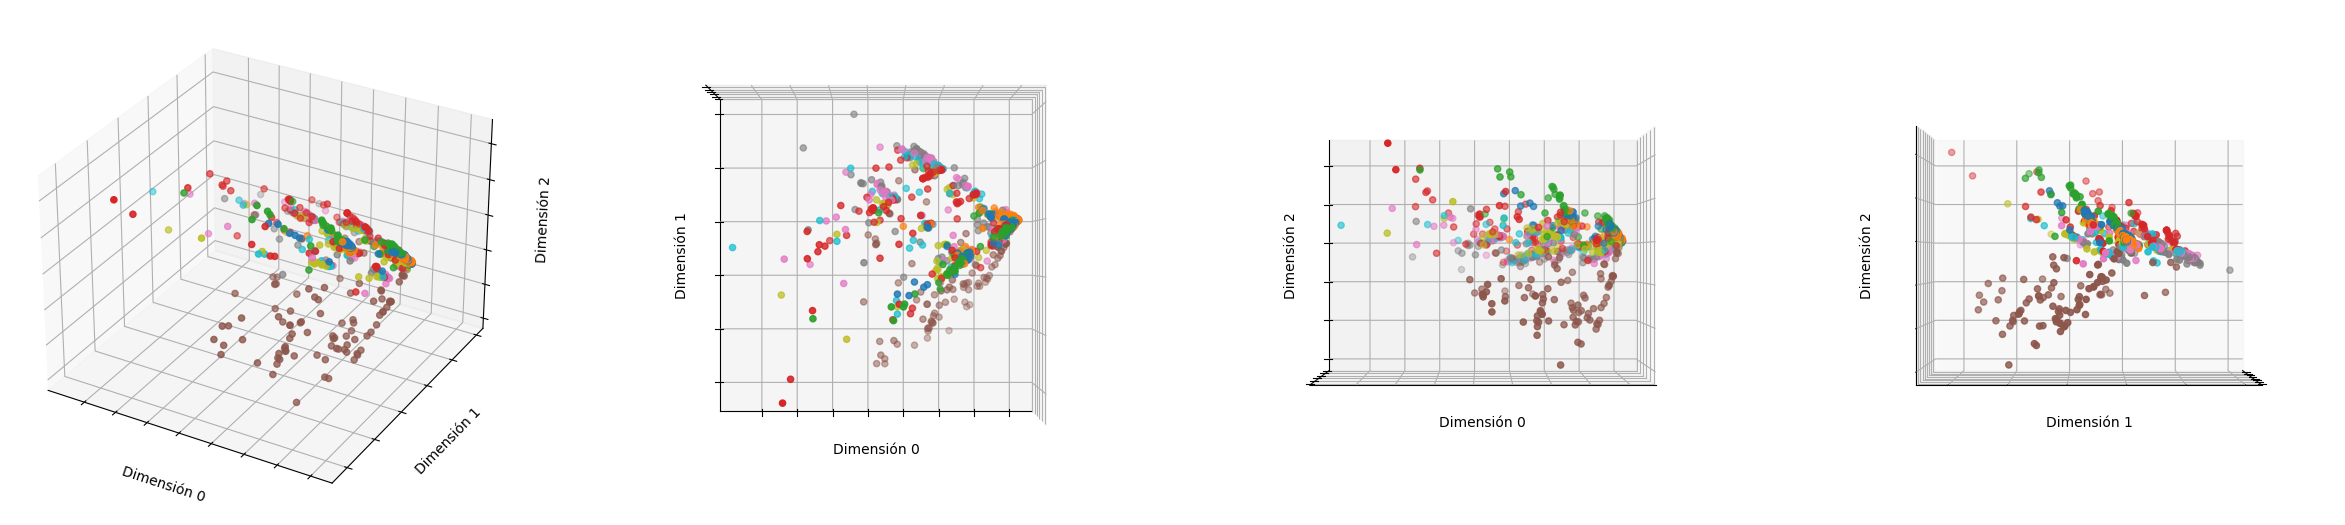

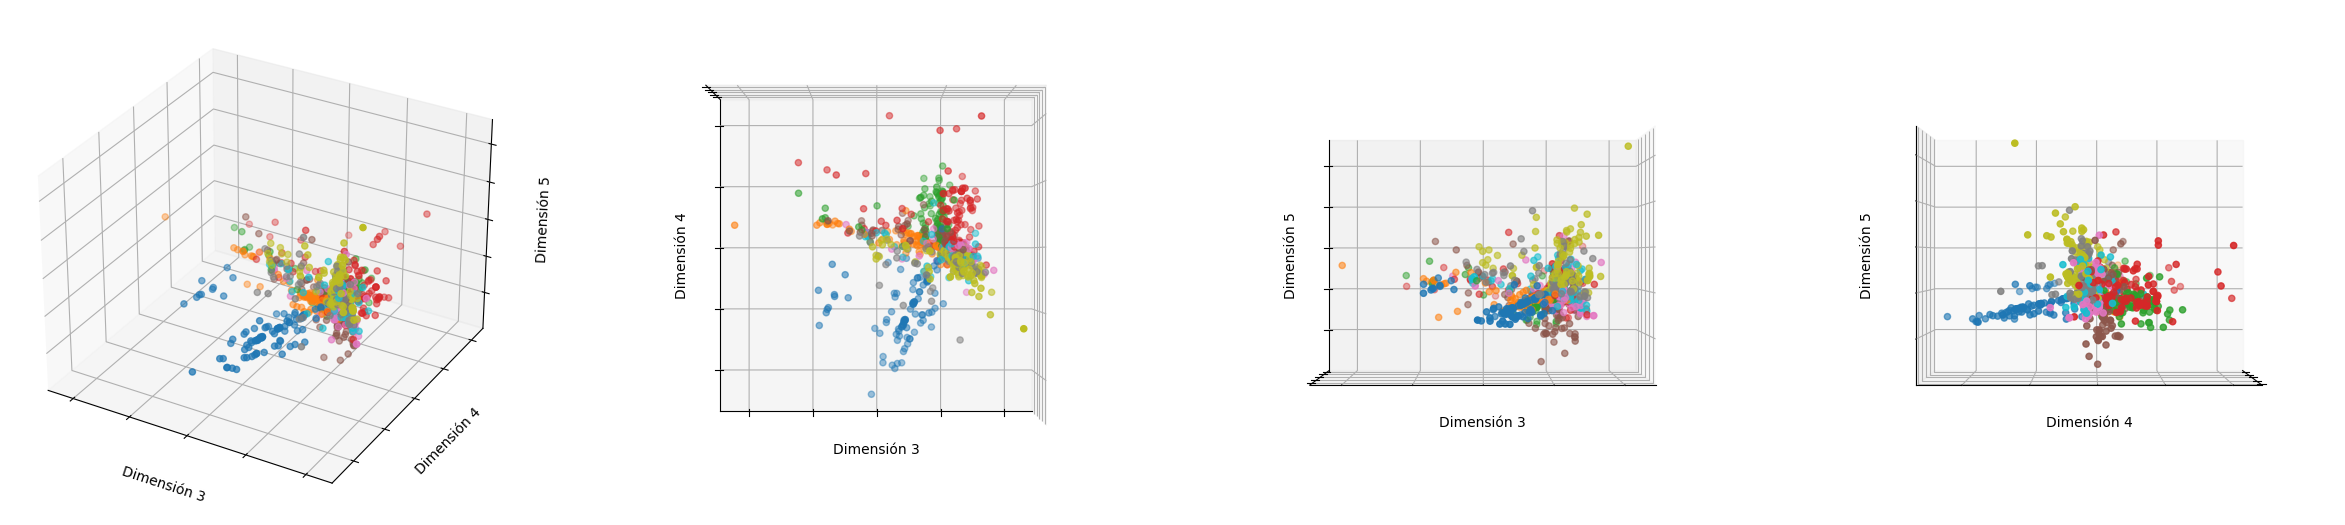

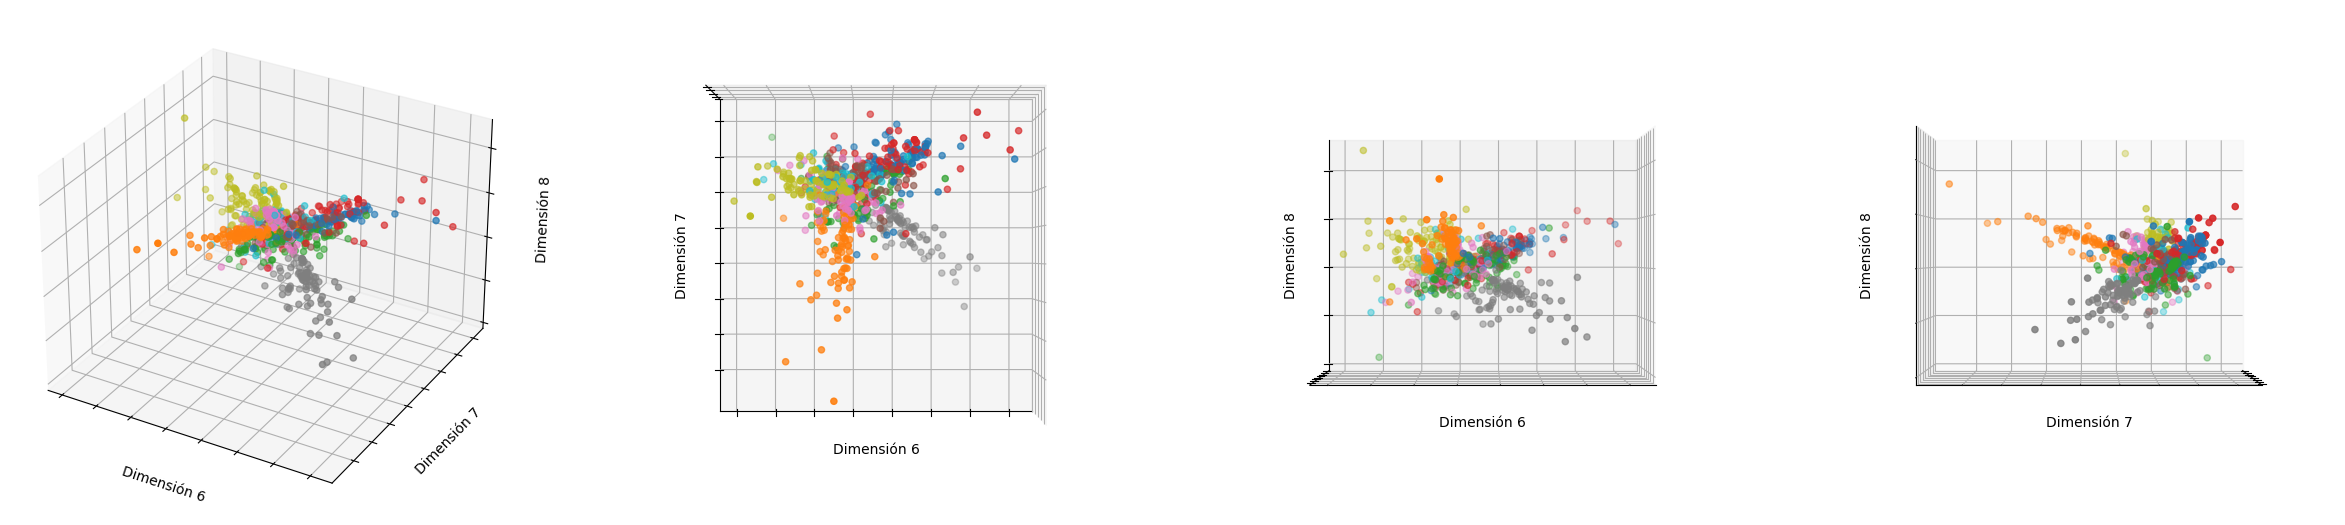

In [ ]:
plotDimReduction(zSanger1, [0,1,2], labels=labels)
plotDimReduction(zSanger1, [3,4,5], labels=labels)
plotDimReduction(zSanger1, [6,7,8], labels=labels)

Si bien estos resultados son buenos, quizás podemos conseguir algo mejor duplicando el *learning rate* para obetener mayor velocidad, y aumentando levente la cantidad de épocas:

In [ ]:
zSanger2 = dimReduction(data, dimOutput = 9, method = 'Sanger', eta = 0.000002, epochs = 1200, seed = 207)

Epoch 0 of 1200. 	Orthogonality: 711.622484000461
Epoch 100 of 1200. 	Orthogonality: 2.5220213113549232
Epoch 200 of 1200. 	Orthogonality: 1.3158668977475432
Epoch 300 of 1200. 	Orthogonality: 0.5996581609437888
Epoch 400 of 1200. 	Orthogonality: 0.32371814539008714
Epoch 500 of 1200. 	Orthogonality: 0.1929904928389658
Epoch 600 of 1200. 	Orthogonality: 0.13060538560960783
Epoch 700 of 1200. 	Orthogonality: 0.0944844495852851
Epoch 800 of 1200. 	Orthogonality: 0.07153974162741064
Epoch 900 of 1200. 	Orthogonality: 0.05738595901826874
Epoch 1000 of 1200. 	Orthogonality: 0.048425666531204004
Epoch 1100 of 1200. 	Orthogonality: 0.042754897041653396
Epoch 1199 of 1200. 	Orthogonality: 0.038777326763751056


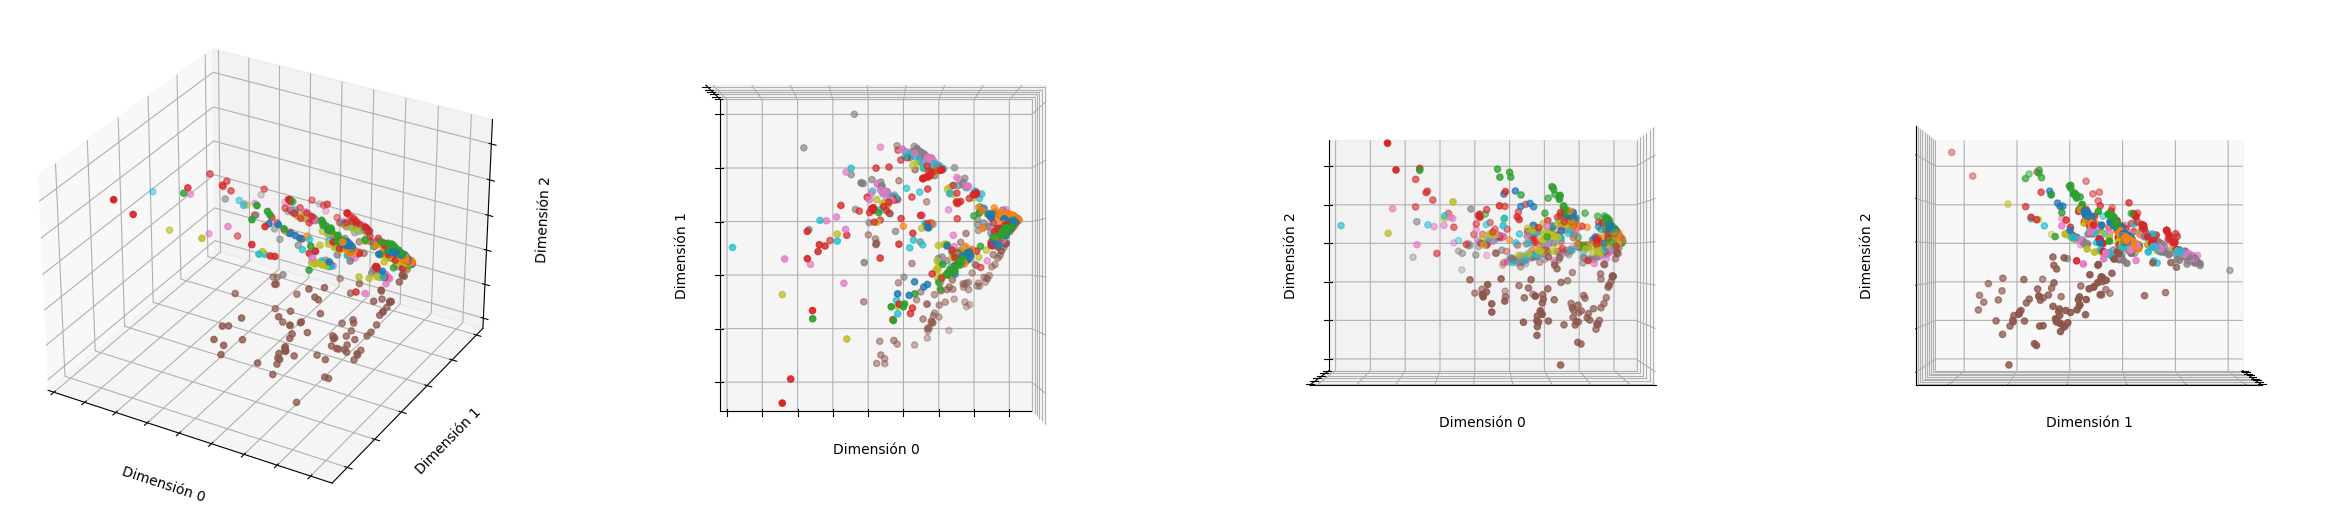

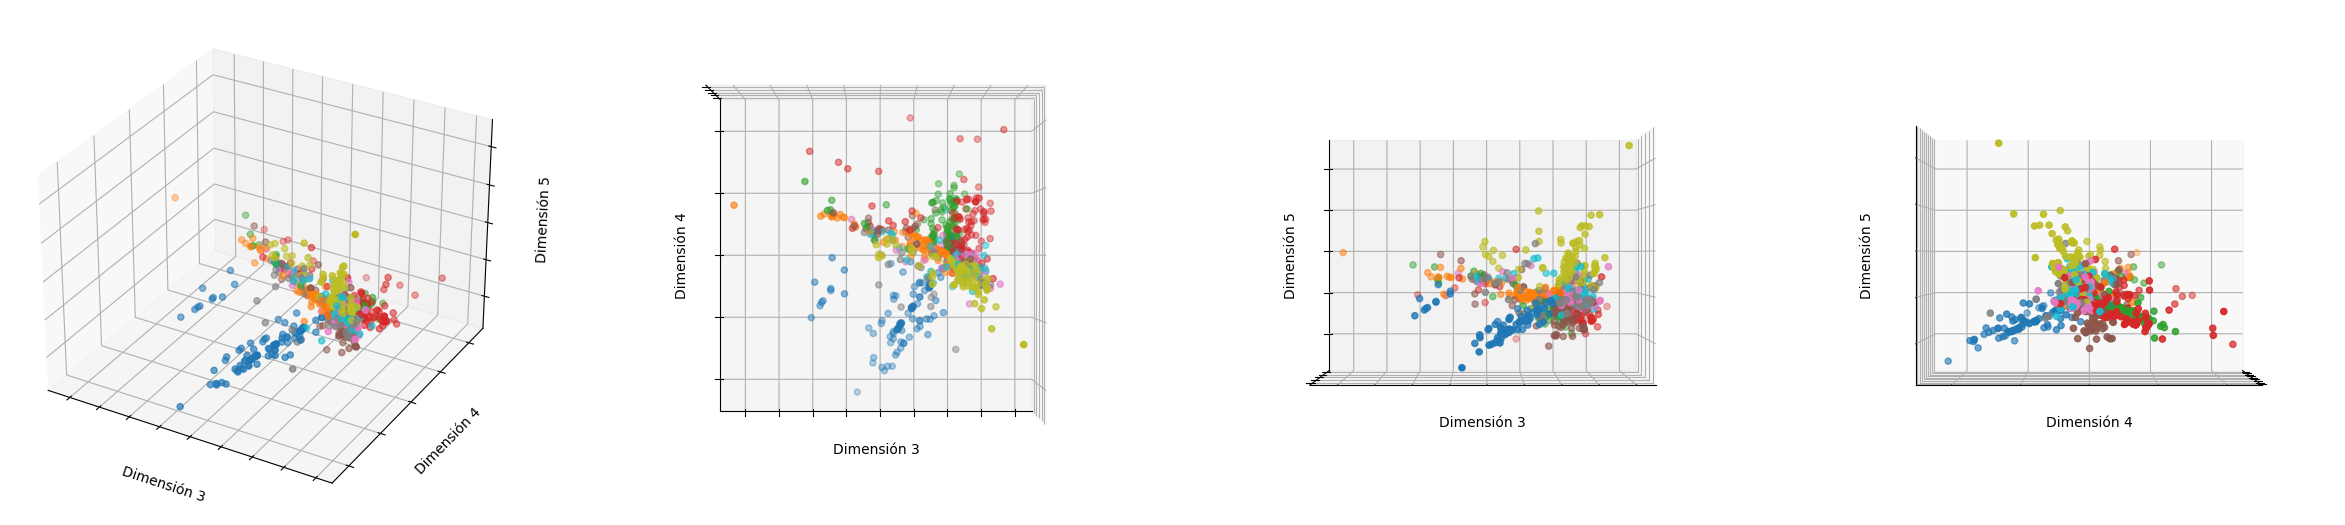

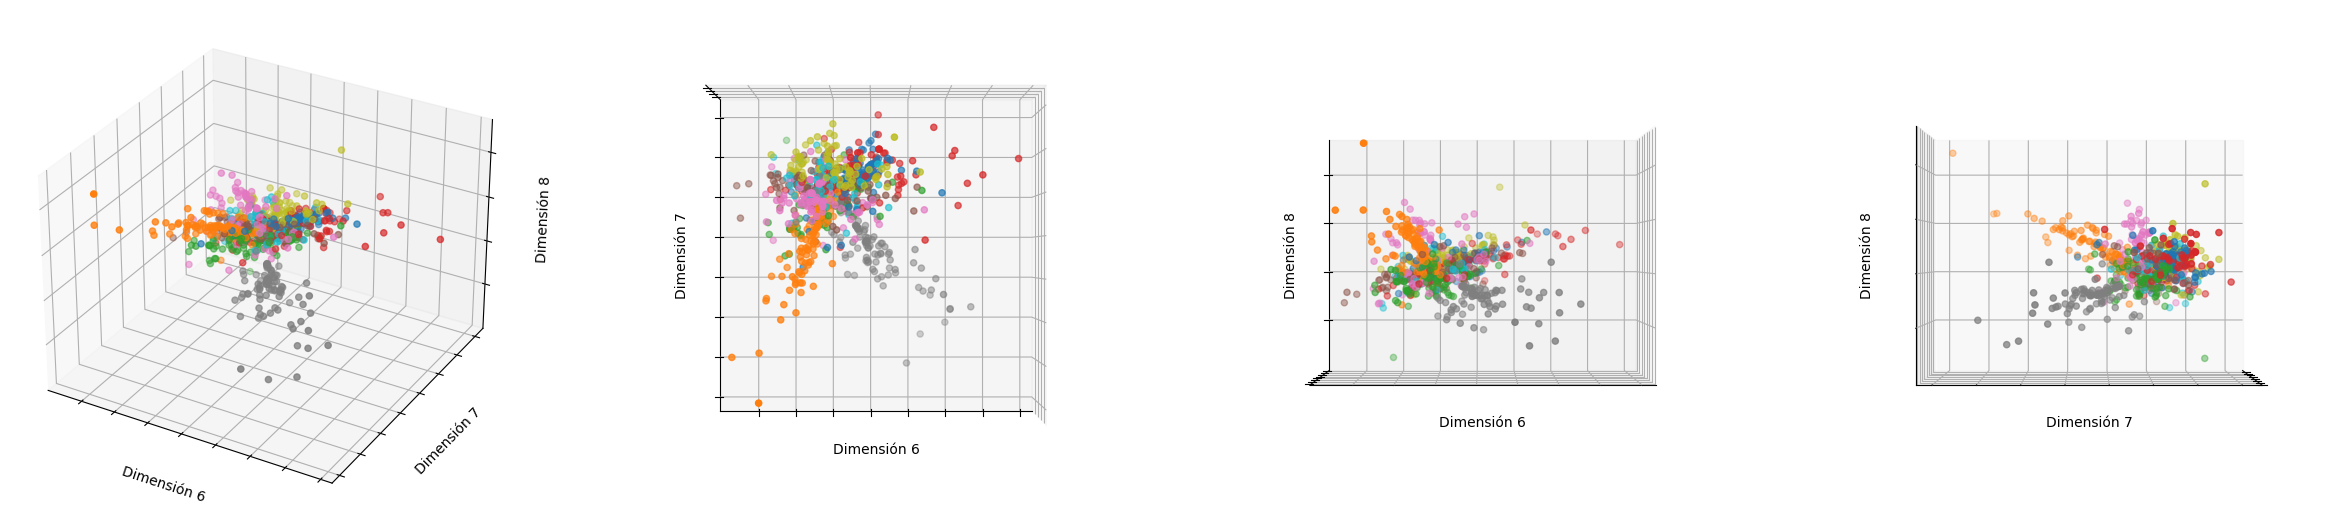

In [ ]:
plotDimReduction(zSanger2, [0,1,2], labels=labels)
plotDimReduction(zSanger2, [3,4,5], labels=labels)
plotDimReduction(zSanger2, [6,7,8], labels=labels)

Estos resultados presentan cierta mejora en la distinción de las categorías originales, como se puede apreciar en las figuras que se ven arriba y en la comparación de las métricas de ortogonalidad.